In [3]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
from image_patching import *

In [4]:
df, split_variables = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]

# Now we are going to work with 2 similar environments

In [5]:
df_similar = df[df['category'].isin(['Bedroom', 'LivingRoom'])]
df_similar

image_path    category
0        ../data/CBIR_15-Scene/00/1.jpg     Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg     Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg     Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg     Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg     Bedroom
...                                 ...         ...
1262  ../data/CBIR_15-Scene/04/1263.jpg  LivingRoom
1263  ../data/CBIR_15-Scene/04/1264.jpg  LivingRoom
1264  ../data/CBIR_15-Scene/04/1265.jpg  LivingRoom
1265  ../data/CBIR_15-Scene/04/1266.jpg  LivingRoom
1266  ../data/CBIR_15-Scene/04/1267.jpg  LivingRoom

[505 rows x 2 columns]

In [6]:
X = df_similar['image_path']
y = df_similar['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)


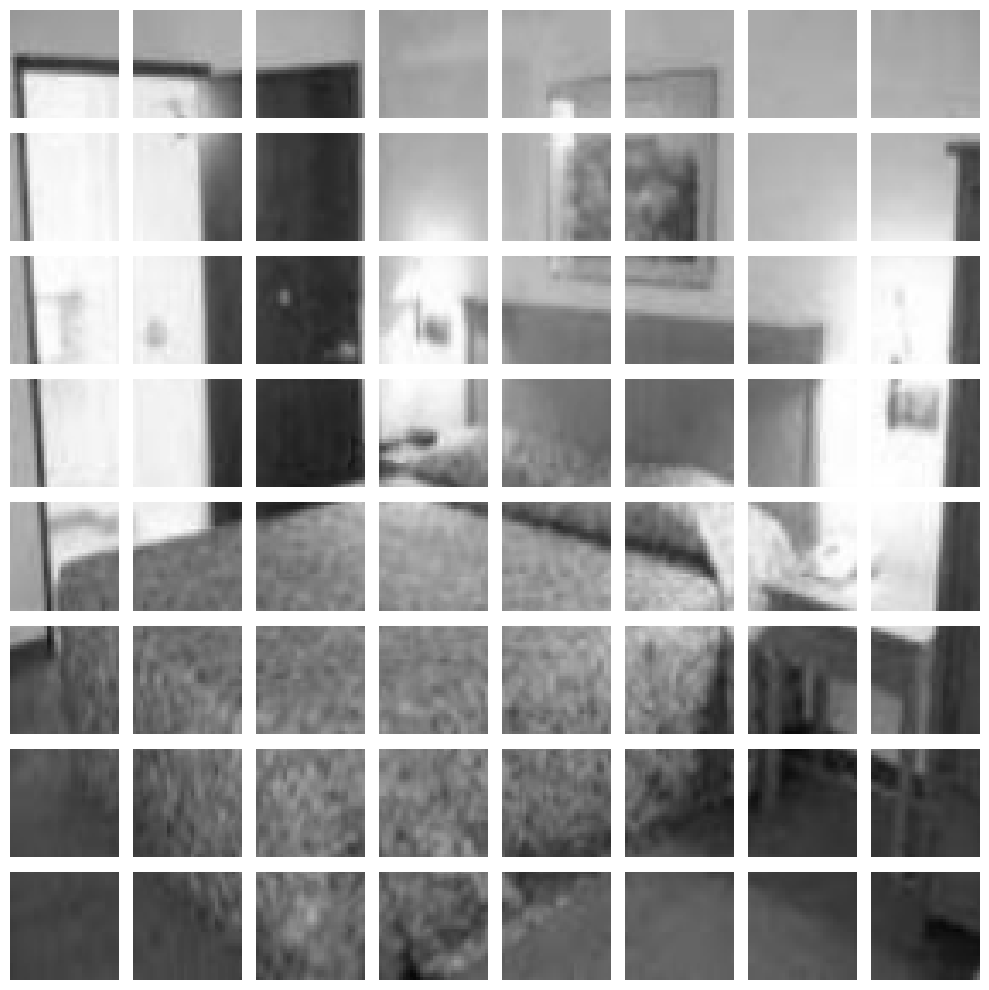

In [7]:
# Função para criar a grid de patches
def plot_patches_grid(patches, patch_size, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(10, 10))
    patch_idx = 0
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            if patch_idx < len(patches):
                axes[i, j].imshow(cv2.cvtColor(patches[patch_idx], cv2.COLOR_BGR2RGB))
                axes[i, j].axis('off')
                patch_idx += 1
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

patch_size = (32,32)

# Carregar a primeira imagem de treino e criar os patches
first_image_path = X_train.iloc[0]
image = cv2.imread(first_image_path)
resized_image = resize_image(image, standard_size)
patches, positions = create_patches(resized_image, patch_size)

# Determinar o número de patches na grid
grid_rows = resized_image.shape[0] // patch_size[0]
grid_cols = resized_image.shape[1] // patch_size[1]

# Plotar a grid de patches
plot_patches_grid(patches, patch_size, (grid_rows, grid_cols))


In [8]:
create_images_set(X_train, X_test, y_train, y_test, patch_size, output_dir_train='patches_train', output_dir_test='patches_test')

In [9]:
patches_array = load_patches_by_category('patches_train', y, patch_size)


In [10]:
print(patches_array)

{'Bedroom': array([[243, 242, 243, ..., 255, 255, 255],
       [245, 244, 244, ..., 255, 255, 255],
       [161, 164, 168, ..., 243, 242, 242],
       ...,
       [168, 169, 168, ..., 132, 131, 130],
       [250, 234, 173, ...,  87,  90,  99],
       [190, 138, 124, ..., 105, 103, 101]], dtype=uint8), 'LivingRoom': array([[124, 122, 122, ..., 133, 132, 131],
       [ 55,  56,  56, ..., 215, 216, 223],
       [156, 157, 148, ...,  89, 107,  86],
       ...,
       [ 95,  73,  72, ..., 120, 119, 122],
       [ 44,  43,  43, ..., 253, 251, 251],
       [138, 124, 114, ..., 158, 151, 159]], dtype=uint8)}


In [44]:
from sklearn.decomposition import PCA

def normalize_patches(patches):
    patches = patches.astype(np.float32)
    mean = np.mean(patches, axis=0)
    std = np.std(patches, axis=0)
    normalized_patches = (patches - mean) / std
    return normalized_patches

# Aplicar PCA para cada categoria e visualizar componentes
def apply_pca_and_visualize(patches_by_category, n_components=1024):
    pca_by_category = {}
    num_components_95_dict = {}
    for category, patches in patches_by_category.items():
        if patches.size == 0:
            continue  # Pular se não houver patches para esta categoria
        
        # Normalizar patches
        patches = normalize_patches(patches)
        
        pca = PCA(n_components=n_components)
        pca.fit(patches)
        components = pca.components_
        variance = pca.explained_variance_
        
        # Plotar os 320 primeiros componentes principais
        fig, axes = plt.subplots(16, 20, figsize=(20, 16))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(components[i].reshape(32, 32), cmap='gray')
            ax.axis('off')
        plt.suptitle(f'{n_components} Principal Components  - Category: {category}')
        plt.show()
        
        # Plotar a log-variância dos componentes principais
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(variance))
        plt.title(f'Log-Variace of Principal Components - Category: {category}')
        plt.xlabel('Index of the Principal Component')
        plt.ylabel('Log-Variance')
        plt.grid(True)
        plt.show()

        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

        pca_by_category[category] = pca
        num_components_95_dict[category] = num_components_95

        print("Category: " + category)
        print("Number of components that explain 95% of variance: " + str(num_components_95))

    
    min_num_components = min(num_components_95_dict.values())
    return pca_by_category, min_num_components

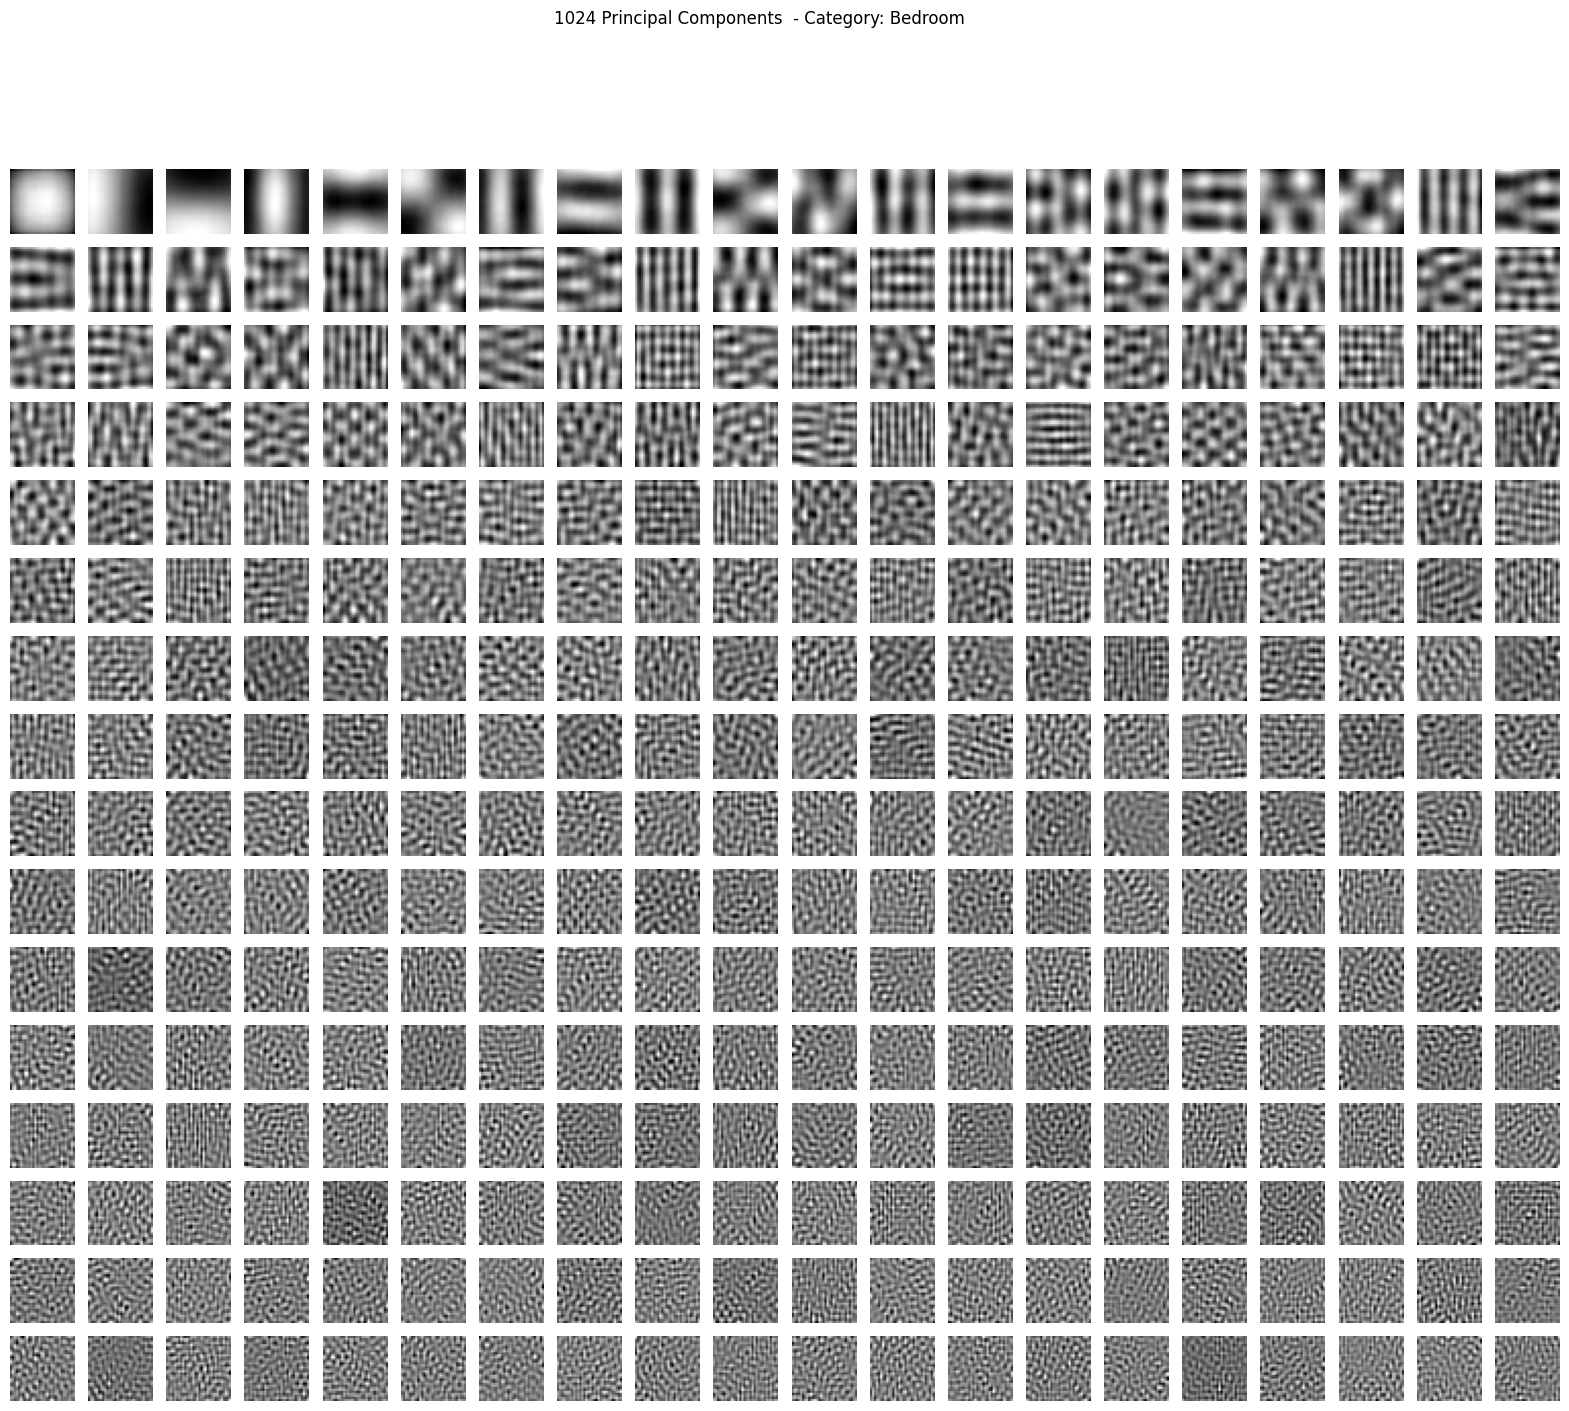

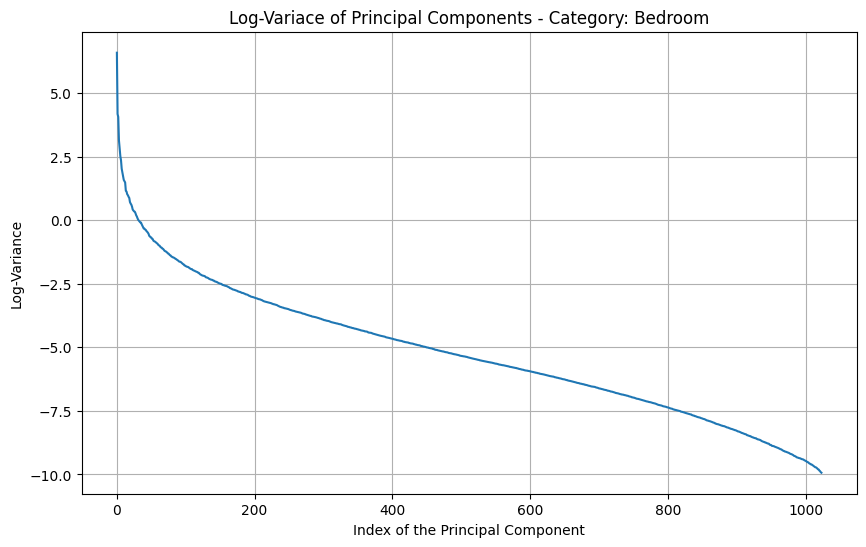

Category: Bedroom
Number of components that explain 95% of variance: 26


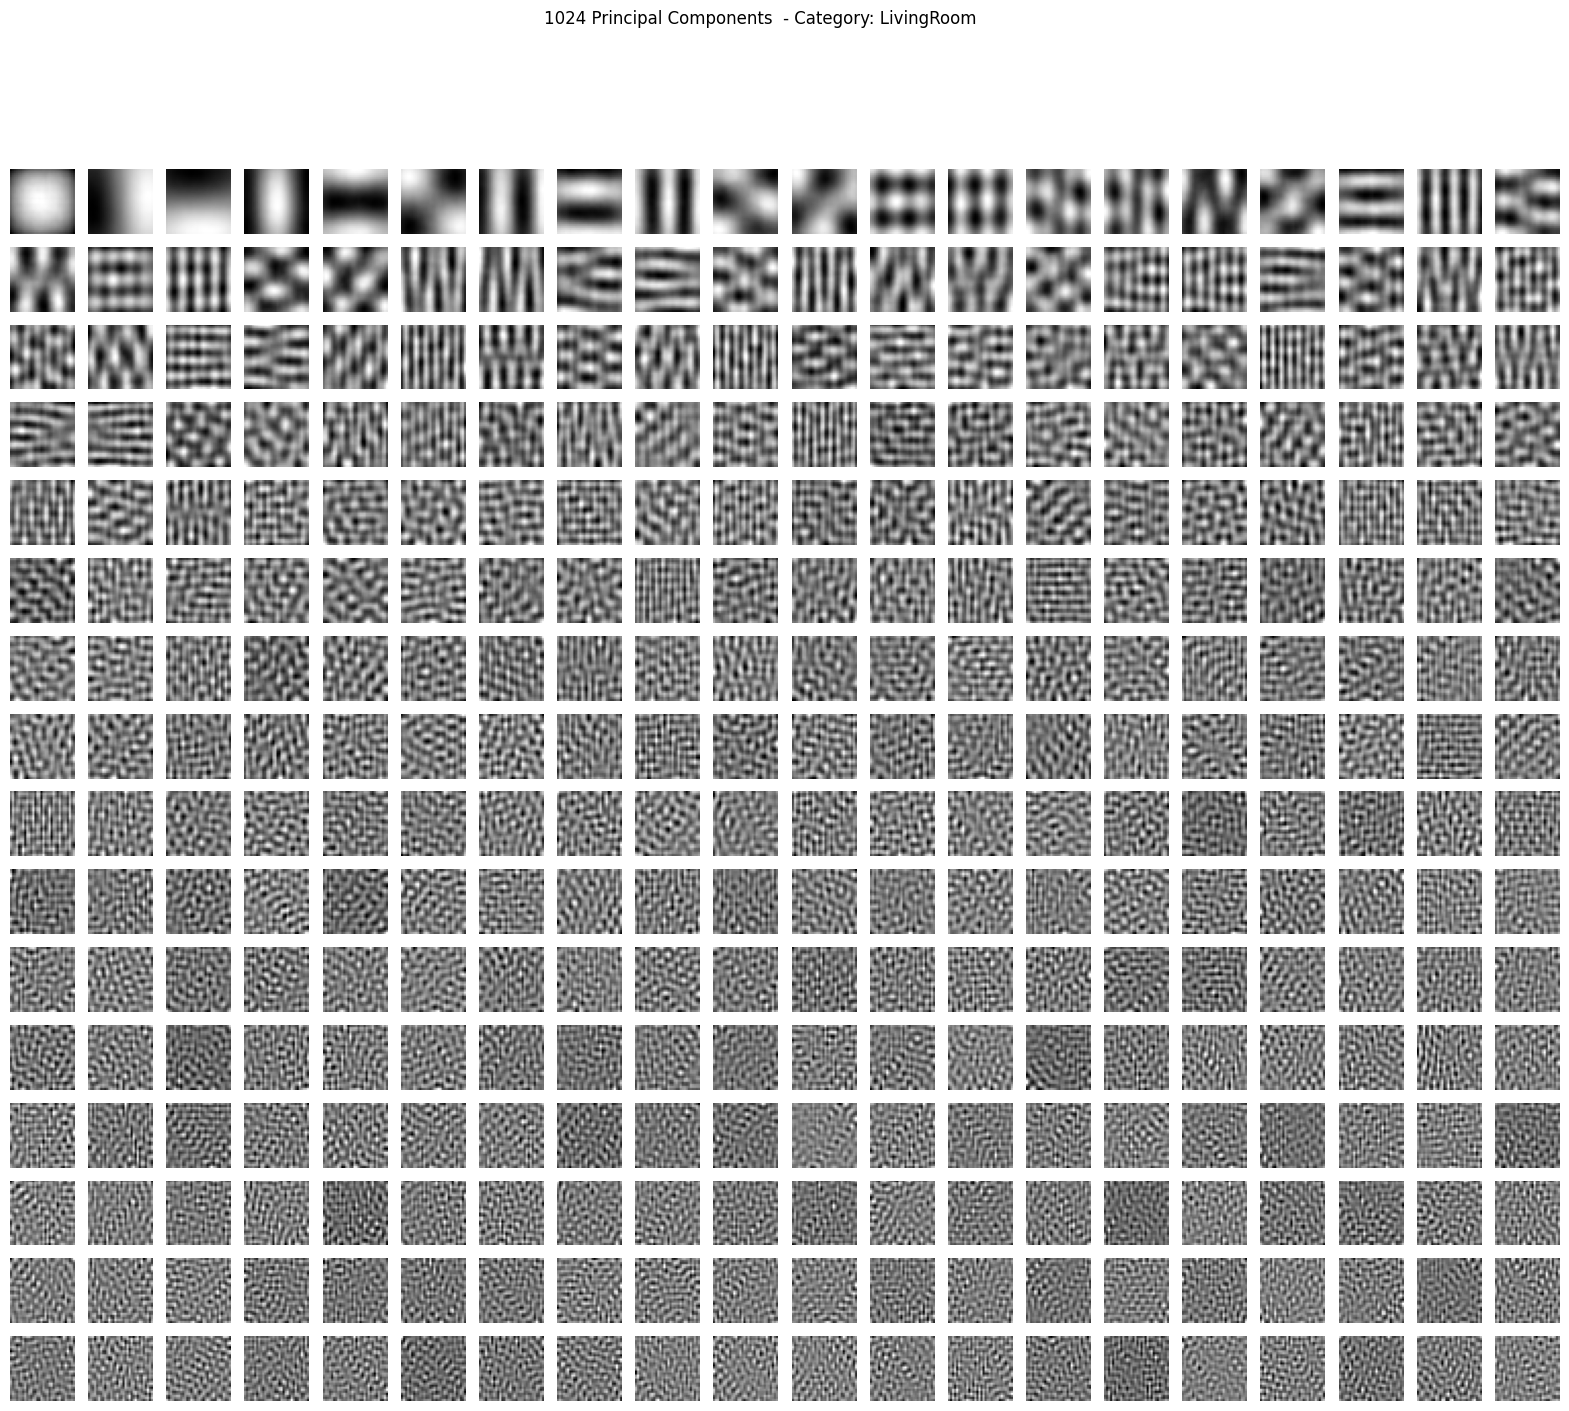

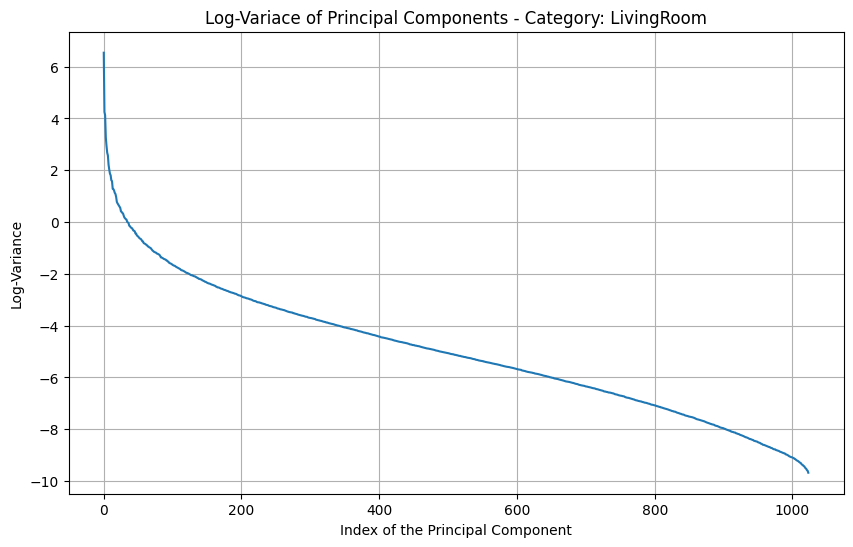

Category: LivingRoom
Number of components that explain 95% of variance: 31
{'Bedroom': PCA(n_components=1024), 'LivingRoom': PCA(n_components=1024)}


In [45]:
pca_by_category, min_components = apply_pca_and_visualize(patches_array)
print(pca_by_category)

In [49]:
def plot_pca_projections(pca_dict_by_category, patches_by_category, n_components):
    fig, axes = plt.subplots(n_components // 2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    plot_idx = 0
    for i in range(n_components - 1):
        for j in range(i + 1, n_components):
            if plot_idx >= len(axes):
                break
            for k, (category, pca) in enumerate(pca_dict_by_category.items()):
                patches = patches_by_category[category]
                
                # Normalizar patches
                patches = normalize_patches(patches)
                
                # Projetar nos componentes principais
                projected_patches = pca.transform(patches)[:, :n_components]
                
                axes[plot_idx].scatter(projected_patches[:, i], projected_patches[:, j], alpha=0.5, label=category, color=colors[k % len(colors)])
            
            axes[plot_idx].set_xlabel(f'Principal Component {i + 1}')
            axes[plot_idx].set_ylabel(f'Principal Component {j + 1}')
            axes[plot_idx].set_title(f'Projection on Principal Components {i + 1} and {j + 1}')
            plot_idx += 1
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

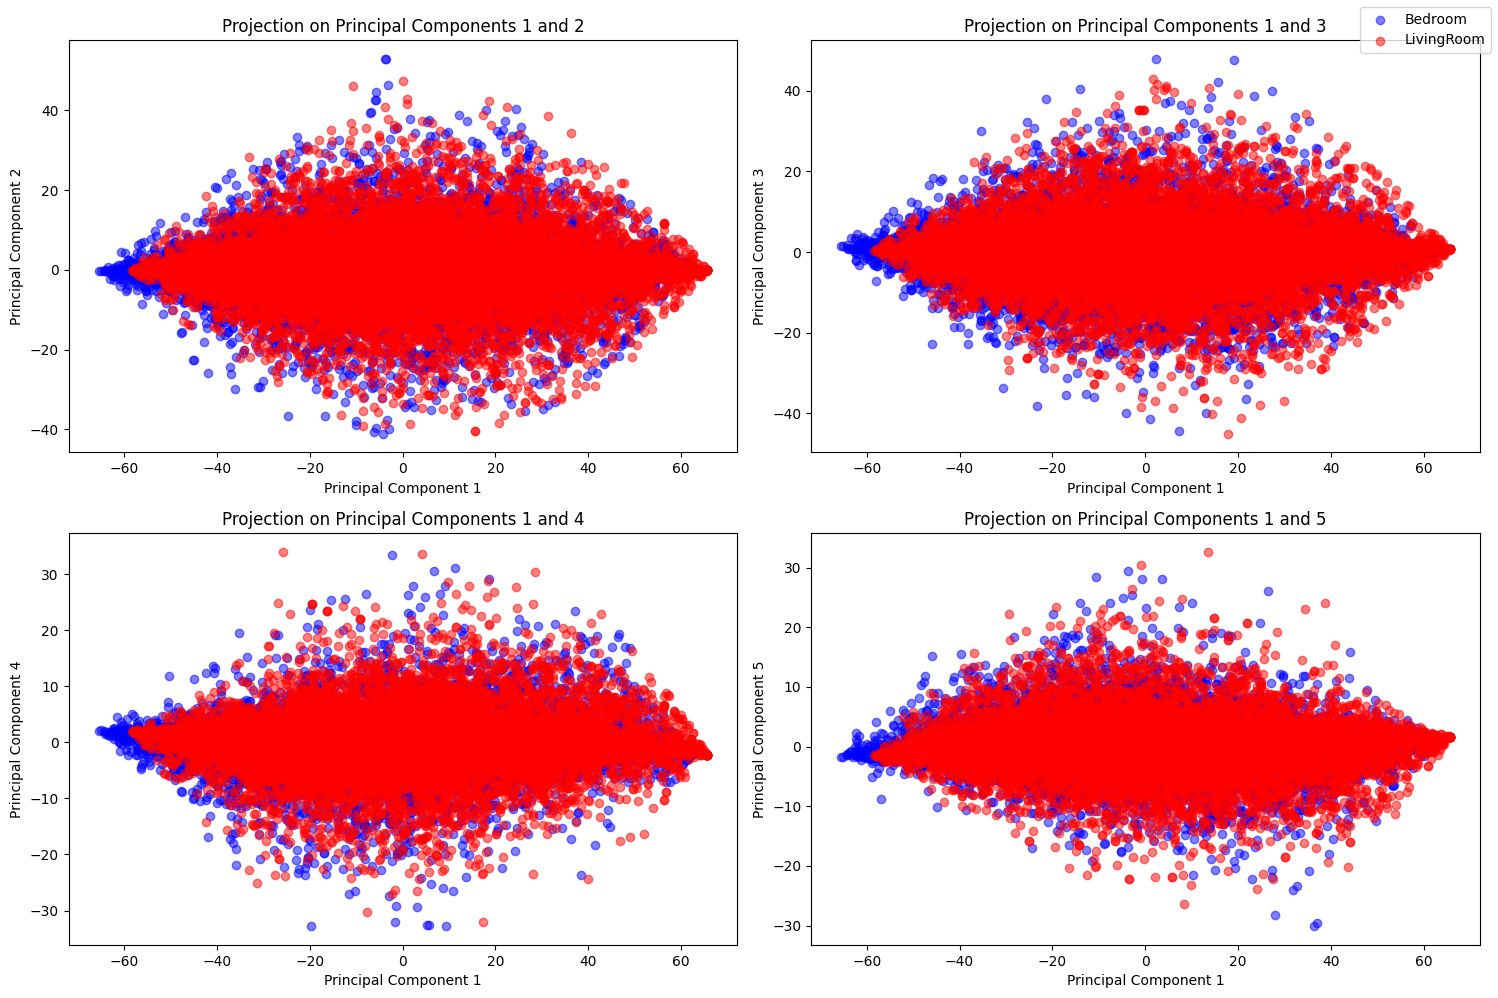

In [52]:
plot_pca_projections(pca_by_category, patches_array, 5)